In [ ]:
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchinfo

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from transformers import PatchTSTConfig, PatchTSTForClassification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torchinfo import summary

In [ ]:
data_folder = "/content/drive/My Drive/Normalized3/Final/"
data_list, labels_list = [], []
# Load dataset
for file_name in os.listdir(data_folder):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path, header=0)
        df = df.select_dtypes(include=[np.number])  # Drop non-numeric columns
        if df.shape != (92, 52):
            print(f"Skipping {file_name} due to incorrect shape: {df.shape}")
            continue
        data_list.append(df.values[:91])  # Take only the first 91 rows
        label = int(file_name.split("_")[-1].split(".")[0])  # Extract label
        labels_list.append(label)

# Convert to NumPy arrays
X = np.array(data_list)  # Shape: (num_samples, 92, 52)
y = np.array(labels_list)  # Shape: (num_samples,)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, 52)).reshape(len(data_list), 91, 52)

# Split into train/test (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Convert to PyTorch tensors
X_train, X_test = map(
    lambda x: torch.tensor(x, dtype=torch.float32), [X_train, X_test]
)
y_train, y_test = map(lambda y: torch.tensor(y, dtype=torch.long), [y_train, y_test])
# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, X_test, y_train, y_test = (
    X_train.to(device),
    X_test.to(device),
    y_train.to(device),
    y_test.to(device),
)


In [ ]:
config = PatchTSTConfig(
    num_input_channels=52,  # Features per timestep
    num_targets=2,  # Binary classification
    context_length=91,  # Sequence length
    patch_length=12,
    stride=12,
     dropout=0.5,
    use_cls_token=True,
)

# Initialize PatchTST model
model = PatchTSTForClassification(config=config).to(device)

In [ ]:
batch_size = 16
train_loader = DataLoader(
    TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)  # Increase weight decay


# Training Loop
epochs = 200
losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(past_values=X_batch).prediction_logits
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")



Epoch 1/200, Loss: 0.6963
Epoch 2/200, Loss: 0.7048
Epoch 3/200, Loss: 0.6819
Epoch 4/200, Loss: 0.6692
Epoch 5/200, Loss: 0.6455
Epoch 6/200, Loss: 0.6287
Epoch 7/200, Loss: 0.5868
Epoch 8/200, Loss: 0.6101
Epoch 9/200, Loss: 0.5352
Epoch 10/200, Loss: 0.5304
Epoch 11/200, Loss: 0.4756
Epoch 12/200, Loss: 0.4397
Epoch 13/200, Loss: 0.5004
Epoch 14/200, Loss: 0.4746
Epoch 15/200, Loss: 0.3838
Epoch 16/200, Loss: 0.3609
Epoch 17/200, Loss: 0.3117
Epoch 18/200, Loss: 0.3276
Epoch 19/200, Loss: 0.3024
Epoch 20/200, Loss: 0.3011
Epoch 21/200, Loss: 0.2138
Epoch 22/200, Loss: 0.1960
Epoch 23/200, Loss: 0.1557
Epoch 24/200, Loss: 0.1051
Epoch 25/200, Loss: 0.0886
Epoch 26/200, Loss: 0.0543
Epoch 27/200, Loss: 0.0527
Epoch 28/200, Loss: 0.0566
Epoch 29/200, Loss: 0.0341
Epoch 30/200, Loss: 0.0261
Epoch 31/200, Loss: 0.0161
Epoch 32/200, Loss: 0.0118
Epoch 33/200, Loss: 0.0087
Epoch 34/200, Loss: 0.0079
Epoch 35/200, Loss: 0.0059
Epoch 36/200, Loss: 0.0046
Epoch 37/200, Loss: 0.0045
Epoch 38/2

In [ ]:
print("Model Summary:\n")
summary(model, input_size=(16, 91, 52))  # Ensure batch size and dimensions match


Model Summary:



Layer (type:depth-idx)                                  Output Shape              Param #
PatchTSTForClassification                               [16, 2]                   --
├─PatchTSTModel: 1-1                                    [16, 52, 80, 12]          --
│    └─PatchTSTScaler: 2-1                              [16, 91, 52]              --
│    │    └─PatchTSTStdScaler: 3-1                      [16, 91, 52]              --
│    └─PatchTSTPatchify: 2-2                            [16, 52, 80, 12]          --
│    └─Identity: 2-3                                    [16, 52, 80, 12]          --
│    └─PatchTSTEncoder: 2-4                             [16, 52, 81, 128]         --
│    │    └─PatchTSTEmbedding: 3-2                      [16, 52, 80, 128]         1,664
│    │    └─PatchTSTPositionalEncoding: 3-3             [16, 52, 81, 128]         10,496
│    │    └─ModuleList: 3-4                             --                        594,816
├─PatchTSTClassificationHead: 1-2               

In [ ]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=fedd097a9acbe2f2dbb3a5adae746ffbe62a298788cfc7c851dc3affc4f69fae
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=9fddf7a27b51b5b42029a325bf05f63ed5805b41b0fcdce432dbaca61238fb8d
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [ ]:
import torch.nn as nn
from fvcore.nn import FlopCountAnalysis, flop_count_table

# Create a wrapper so the input tensor goes as past_values
class PatchTSTWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(past_values=x)

# Wrap your model
wrapped_model = PatchTSTWrapper(model)

# Dummy input matching your model's expected shape
dummy_input = torch.randn(1, 91, 52).to(device)

# Move the wrapper to the same device
wrapped_model.to(device)

# Compute FLOPs
flops = FlopCountAnalysis(wrapped_model, dummy_input)
print(flop_count_table(flops))


| module                                           | #parameters or shape   | #flops    |
|:-------------------------------------------------|:-----------------------|:----------|
| model                                            | 0.62M                  | 2.759G    |
|  model.encoder                                   |  0.607M                |  2.759G   |
|   model.encoder.embedder.input_embedding         |   1.664K               |   6.39M   |
|    model.encoder.embedder.input_embedding.weight |    (128, 12)           |           |
|    model.encoder.embedder.input_embedding.bias   |    (128,)              |           |
|   model.encoder.positional_encoder               |   10.496K              |   0       |
|    model.encoder.positional_encoder.cls_token    |    (1, 1, 1, 128)      |           |
|    model.encoder.positional_encoder.position_enc |    (81, 128)           |           |
|   model.encoder.layers                           |   0.595M               |   2.753G  |
|    model

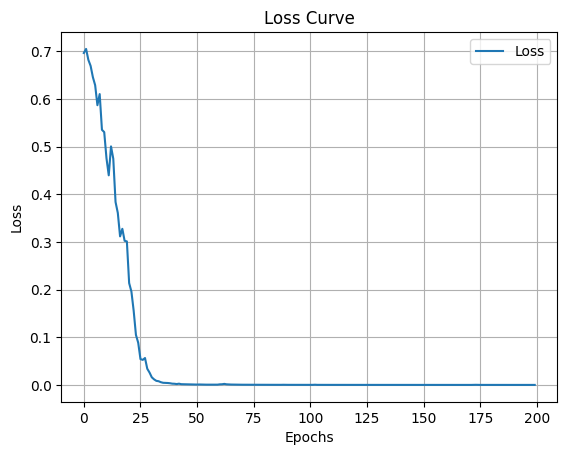

In [ ]:
# Plot loss curve
plt.plot(range(epochs), losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

Accuracy: 0.9085

Classification Report:
              precision    recall  f1-score   support

      Absent       0.89      0.94      0.92        87
     Present       0.93      0.87      0.90        77

    accuracy                           0.91       164
   macro avg       0.91      0.91      0.91       164
weighted avg       0.91      0.91      0.91       164



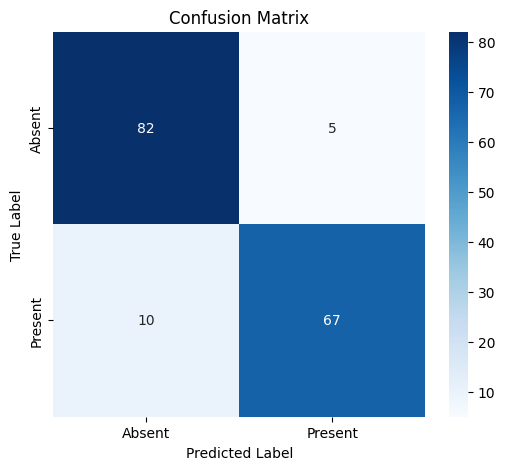

In [ ]:
model.eval()
X_full, y_full = torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(
    y, dtype=torch.long
).to(device)

with torch.no_grad():
    full_outputs = model(past_values=X_full).prediction_logits
    full_predictions = torch.argmax(full_outputs, dim=1)

y_full_cpu, full_predictions_cpu = y_full.cpu().numpy(), full_predictions.cpu().numpy()

# Compute accuracy
full_acc = accuracy_score(y_full_cpu, full_predictions_cpu)
print(f"Accuracy: {full_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_full_cpu, full_predictions_cpu, target_names=["Absent", "Present"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_full_cpu, full_predictions_cpu)
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Absent", "Present"],
    yticklabels=["Absent", "Present"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import torch
import numpy as np
import pickle

# Ensure model is in evaluation mode
model.eval()

# Get predictions for the full dataset (train + test)
X_full_tensor = torch.tensor(X, dtype=torch.float32).to(device)  # Use X (full dataset)
with torch.no_grad():
    outputs = model(past_values=X_full_tensor).prediction_logits  # Shape: (164, 2)
    y_pred_patchtst = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Extract probability of class 1

# Save full predictions
save_dir = "/content/drive/My Drive/stacking_preds/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

file_path = os.path.join(save_dir, "patchtst2.pkl")
with open(file_path, "wb") as f:
    pickle.dump(y_pred_patchtst, f)

print(f"Saved PatchTST predictions for all 164 samples at: {file_path}")


Saved PatchTST predictions for all 164 samples at: /content/drive/My Drive/stacking_preds/patchtst2.pkl
